## Setup

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
import sys
sys.path.append("..")

# Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import m5.preprocessing
import m5.config as cfg

import lightgbm as lgb
import gc

# Library settings
pd.options.display.max_columns = 999
plt.rcParams["figure.figsize"] = (14, 4)

In [3]:
feature_names = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
    'sell_price', 'sales_lag_1', 'sales_lag_2', 'sales_lag_3',
    'sales_lag_4', 'sales_lag_5', 'sales_lag_6', 'sales_lag_7',
    'sales_lag_8', 'sales_lag_9', 'sales_lag_10', 'sales_lag_11',
    'sales_lag_12', 'sales_lag_13', 'sales_lag_14',
]

categorical_features = [
    'id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'd', 'wday', 'month', 'year', 'event_name_1', 'event_type_1',
    'event_name_2', 'event_type_2', 'snap_CA', 'snap_TX', 'snap_WI',
]

## Preprocessing

In [3]:
m5.preprocessing.prepare_base_data(cfg.DATA_DIR, cfg.DATA_PROCESSED_DIR)

In [4]:
m5.preprocessing.prepare_dataset(cfg.DATA_PROCESSED_DIR, cfg.TARGET, cfg.N_LAGS)

In [3]:
m5.preprocessing.prepare_train_val_split(cfg.DATA_PROCESSED_DIR, cfg.FH)

Size validation dataset: 853720


In [6]:
m5.preprocessing.prepare_dataset_binaries(cfg.DATA_PROCESSED_DIR, feature_names, categorical_features)

[LightGBM] [Warning] Met categorical feature which contains sparse values. Consider renumbering to consecutive integers started from zero
[LightGBM] [Info] Construct bin mappers from text data time 0.48 seconds
[LightGBM] [Info] Saving data to binary file ../data/processed/train.bin
[LightGBM] [Info] Saving data to binary file ../data/processed/val.bin


## Train

In [4]:
train = lgb.Dataset(str(cfg.DATA_PROCESSED_DIR / "train.bin"))
val = lgb.Dataset(str(cfg.DATA_PROCESSED_DIR / "val.bin"))

In [5]:
lgbm_params = {
    "task": "train",
    "objective": "tweedie",
    "num_iterations": 1000,
    "learning_rate": 0.1,
    "num_leaves": 31,
    "num_threads": 4,
    "early_stopping_round": 100,
}

In [6]:
model = lgb.train(lgbm_params, train, valid_sets=[val])

/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:148: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))
/home/ariel/anaconda3/envs/merlion/lib/python3.9/site-packages/lightgbm/engine.py:153: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  _log_warning("Found `{}` in params. Will use it instead of argument".format(alias))


[LightGBM] [Info] Load from binary file ../data/processed/train.bin
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 3.139551 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 33365
[LightGBM] [Info] Number of data points in the train set: 44661920, number of used features: 32
[LightGBM] [Info] Start training from score 0.356451
[1]	valid_0's tweedie: 4.60423
Training until validation scores don't improve for 100 rounds
[2]	valid_0's tweedie: 4.51087
[3]	valid_0's tweedie: 4.4314
[4]	valid_0's tweedie: 4.35782
[5]	valid_0's tweedie: 4.2922
[6]	valid_0's tweedie: 4.23677
[7]	valid_0's tweedie: 4.18876
[8]	valid_0's tweedie: 4.14652
[9]	valid_0's tweedie: 4.10928
[10]	valid_0's tweedie: 4.07704
[11]	valid_0's tweedie: 4.04885
[12]	valid_0's tweedie: 4.02331
[13]	valid_0's tweedie: 4.0017
[14]	valid_0's tweedie: 3.98347
[15]	valid_0's tweedi

In [10]:
model.save_model(str(cfg.ROOT_DIR / "models/model_lvl_12.txt"))

## Predict

In [1]:
model = lgb.Booster(model_file=str(cfg.MODEL_DIR / "model_lvl_12.txt"))

NameError: name 'lgb' is not defined

In [65]:
val = pd.read_parquet(cfg.DATA_PROCESSED_DIR / "val.parquet")

In [97]:
X = val.drop(columns=["sales"]).groupby("id", group_keys=False).apply(lambda df: df.head(1))
#y = val["sales"]

In [98]:
pred_list = []
lag_cols = [col for col in X.columns if "lag" in col]
for i in range(0, cfg.FH):
    pred = model.predict(X)
    X[lag_cols] = X[lag_cols].shift(1, axis=1)
    X[lag_cols[0]] = pred
    pred = pd.DataFrame({"fh": i + 1, "fcst": pred})
    pred.index.name = "id"
    pred_list.append(pred)

In [99]:
fcst_df = pd.concat(pred_list).reset_index()

In [108]:
fcst_df

,id,fh,fcst
0,0,1,1.226615
1,1,1,0.880847
2,2,1,1.238306
3,3,1,0.424053
4,4,1,0.612236
...,...,...,...
853715,30485,28,0.785979
853716,30486,28,0.680915
853717,30487,28,0.582155
853718,30488,28,0.277735


In [113]:
fcst_df["d"] = fcst_df["fh"] + val["d"].min() - 1

In [116]:
val_fcst = val.merge(fcst_df, on=["id", "d"])

<AxesSubplot:xlabel='d'>

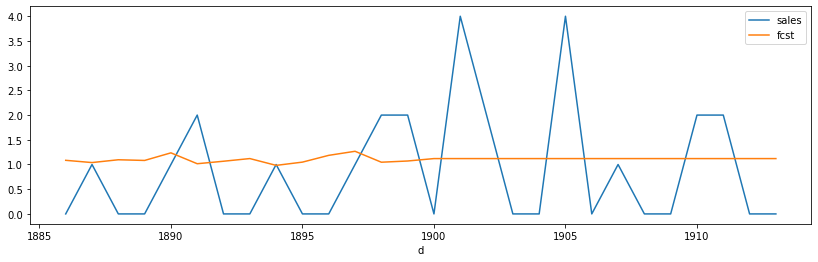

In [136]:
val_fcst.loc[val_fcst["id"] == 3000, ["d", "sales", "fcst"]].set_index("d").plot()

In [139]:
fcst_df = val_fcst[["id", "item_id", "dept_id", "cat_id", "store_id", "state_id", "d", "sales", "fcst"]]

In [164]:
levels = {
    1: ['d'],
    2:['state_id', 'd'],
    3:['store_id', 'd'],
    4:['cat_id', 'd'],
    5:['dept_id', 'd'],
    6:['state_id', 'cat_id', 'd'],
    7:['state_id', 'dept_id', 'd'],
    8:['store_id', 'cat_id', 'd'],
    9:['store_id', 'dept_id', 'd'],
    10:['item_id', 'd'],
    11:['item_id', 'state_id', 'd'],
    12:['item_id', 'store_id', 'd'],
}

In [158]:
fcst_df

,id,item_id,dept_id,cat_id,store_id,state_id,d,sales,fcst
0,0,0,0,0,0,0,1886,2,1.226615
1,0,0,0,0,0,0,1887,1,0.910135
2,0,0,0,0,0,0,1888,1,0.964466
3,0,0,0,0,0,0,1889,0,1.116001
4,0,0,0,0,0,0,1890,4,1.089914
...,...,...,...,...,...,...,...,...,...
853715,30489,3048,6,2,9,2,1909,0,0.658474
853716,30489,3048,6,2,9,2,1910,0,0.658474
853717,30489,3048,6,2,9,2,1911,0,0.658474
853718,30489,3048,6,2,9,2,1912,0,0.658474


In [167]:
fcst_lvl_12 = fcst_df.groupby(levels[12])[["sales", "fcst"]].sum().reset_index()

In [168]:
fcst_lvl_11 = fcst_df.groupby(levels[11])[["sales", "fcst"]].sum().reset_index()

In [175]:
fcst_lvl = fcst_df.groupby(levels[2])[["sales", "fcst"]].sum().reset_index()

In [176]:
fcst_lvl

,state_id,d,sales,fcst
0,0,1886,15482,16724.756453
1,0,1887,15319,16818.545279
2,0,1888,14352,17231.966393
3,0,1889,15601,17937.751947
4,0,1890,18922,18658.453404
...,...,...,...,...
79,2,1909,10595,14411.899528
80,2,1910,10943,14442.641018
81,2,1911,12807,14472.416545
82,2,1912,14862,14488.391832


<AxesSubplot:xlabel='d'>

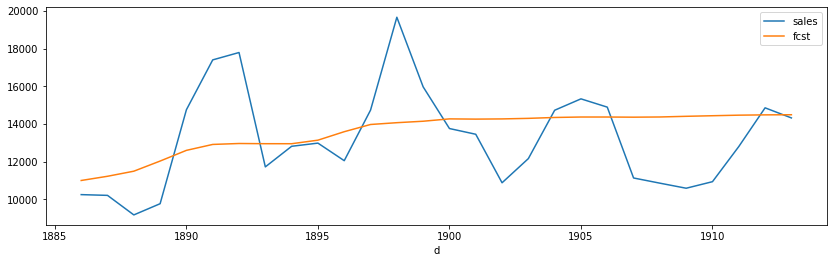

In [179]:
fcst_lvl.loc[(fcst_lvl.state_id == 2), ["d", "sales", "fcst"]].set_index("d").plot()

<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

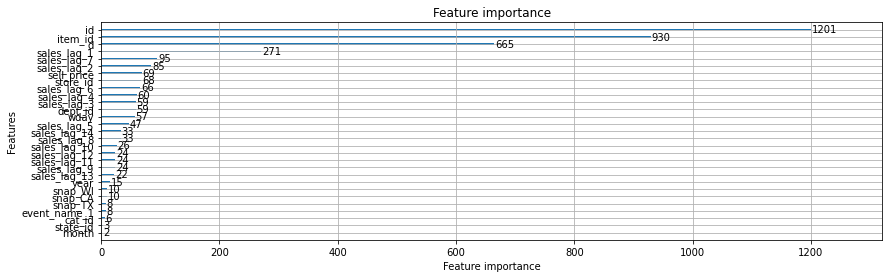

In [182]:
lgb.plot_importance(model)

In [79]:
len(pred_list)

28

In [75]:
np.concatenate(pred_list, axis=1)

AxisError: axis 1 is out of bounds for array of dimension 1

In [68]:
pred_list

[array([1.22661534, 0.88084717, 1.23830586, ..., 0.07606681, 0.02937654,
        0.08713963]),
 array([0.91013496, 0.79238071, 1.33617711, ..., 0.14340888, 0.05761701,
        0.1366027 ]),
 array([0.96446606, 0.82390982, 1.52428257, ..., 0.21276894, 0.0861157 ,
        0.20416952]),
 array([1.11600144, 0.84354012, 1.40061838, ..., 0.25783116, 0.11571528,
        0.27434642]),
 array([1.08991393, 0.7952713 , 1.53141526, ..., 0.3085512 , 0.13143741,
        0.31162161]),
 array([1.14317538, 0.93726515, 1.80252855, ..., 0.34491426, 0.14666852,
        0.34773267]),
 array([1.03611961, 1.04901208, 1.8178766 , ..., 0.34928281, 0.16663592,
        0.39507288]),
 array([1.06560194, 0.95359041, 1.59637921, ..., 0.3920908 , 0.18705877,
        0.44349288]),
 array([1.14117091, 0.98475649, 1.58061867, ..., 0.41112819, 0.19614113,
        0.46502602]),
 array([1.02875938, 1.01903147, 1.64762107, ..., 0.44322622, 0.21145447,
        0.50133202]),
 array([1.05668174, 1.02717939, 1.69328865, ..., 0

In [43]:
X_lags = X[lag_cols]

In [44]:
X_lags

,,sales_lag_1,sales_lag_2,sales_lag_3,sales_lag_4,sales_lag_5,sales_lag_6,sales_lag_7,sales_lag_8,sales_lag_9,sales_lag_10,sales_lag_11,sales_lag_12,sales_lag_13,sales_lag_14
id,,,,,,,,,,,,,,,
0,45090392,NaN,0,1,1,0,2,2,0,2,2,1,2,0,0
1,45093441,NaN,1,2,0,0,0,0,1,2,0,0,0,1,2
2,45096490,NaN,0,12,1,1,1,0,2,4,2,1,0,0,0
3,45099539,NaN,0,1,0,0,1,0,1,0,1,1,0,0,0
4,45102588,NaN,0,0,2,0,1,0,1,2,1,0,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,45105636,NaN,1,0,1,1,0,0,1,0,0,2,0,0,0
30486,45108685,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0
30487,45111734,NaN,0,0,0,0,0,0,0,0,1,0,0,0,0


204